<a href="https://colab.research.google.com/github/ideal-guy/Retail-Customer-Segmentation/blob/main/CustomerSegmentation_OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import warnings
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# Segmenting Customers based upon their buying behaviour and geographical segmenting

## Preprocessing

In [55]:
warnings.filterwarnings('ignore')

df = pd.read_excel("/content/Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


It took a few minutes to load the data, so we keep a copy as a backup.

In [56]:
df1 = df

In [57]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [58]:
df1.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [59]:
df1.Country.nunique()

38

In [60]:
df1.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [61]:
customer_country=df1[['Country','CustomerID']].drop_duplicates()

customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


# Finding recency , frequency and monetary values

In [62]:
#recenccy

day="2012-01-01"
day=pd.to_datetime(day)
df['InvoiceDate']=pd.to_datetime(df["InvoiceDate"])

recency=df.groupby(["CustomerID"]).agg({"InvoiceDate":lambda x:((day-x.max()).days)})

In [63]:
recency.head(10)

,InvoiceDate
CustomerID,
12346.0,347
12347.0,24
12348.0,97
12349.0,40
12350.0,332
12352.0,58
12353.0,226
12354.0,254
12355.0,236


In [64]:
#frequency

freq=df.drop_duplicates(subset="InvoiceNo").groupby(["CustomerID"])[["InvoiceNo"]].count()
freq.head(5)

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [65]:
#monetary

df["total"]=df["Quantity"]*df["UnitPrice"]

In [66]:
money=df.groupby(["CustomerID"])[["total"]].sum()
money

,total
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,176.60


In [74]:
RFM=pd.concat([recency,freq,money], axis=1)
recency.columns=["Recency"]
freq.columns=["Frequency"]
money.columns=["Monetary"]
RFM

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,347,2,0.00
12347.0,24,7,4310.00
12348.0,97,4,1797.24
12349.0,40,1,1757.55
12350.0,332,1,334.40
...,...,...,...
18280.0,299,1,180.60
18281.0,202,1,80.82
18282.0,29,3,176.60


# Applysing Kmeans Clustering Algo

In [75]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

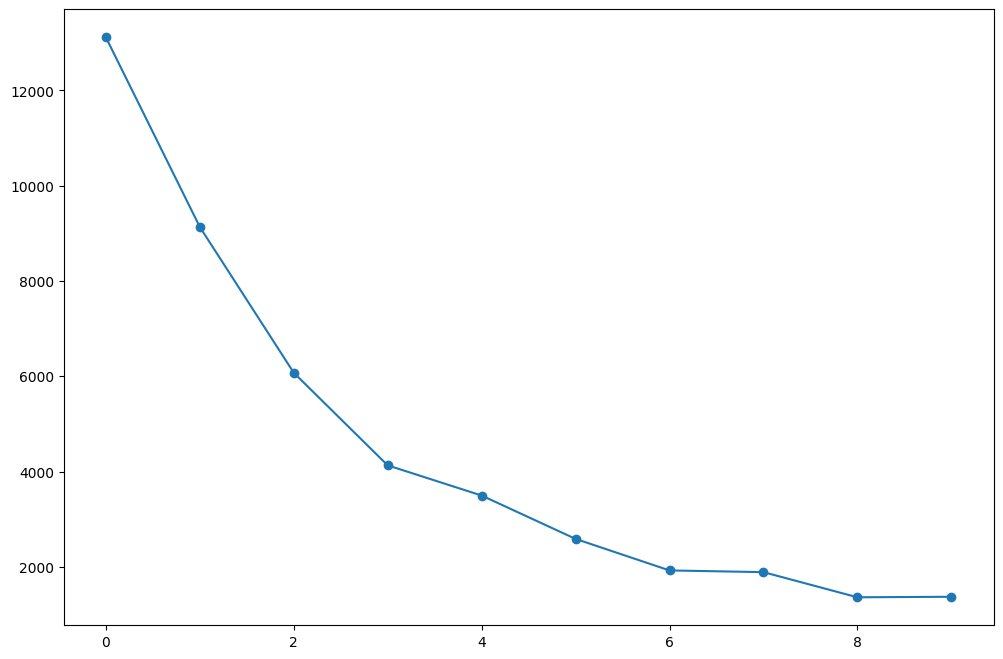

In [76]:
from sklearn.cluster import KMeans

inertia=[]

for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12,8))
plt.plot(inertia, marker="o")

In [77]:
# optimal k = 3 from elbow curve
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Clusters"]=(kmeans.labels_+1)

In [78]:
RFM

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12346.0,347,2,0.00,2
12347.0,24,7,4310.00,1
12348.0,97,4,1797.24,1
12349.0,40,1,1757.55,1
12350.0,332,1,334.40,2
...,...,...,...,...
18280.0,299,1,180.60,2
18281.0,202,1,80.82,2
18282.0,29,3,176.60,1


In [79]:
final = RFM.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean()
final

,Recency,Frequency,Monetary
Clusters,,,
1,61.019403,6.031414,2060.678643
2,266.552279,1.851653,461.081654
3,29.166667,89.000000,182181.981667


In [80]:
def func(row):
    if row["Clusters"]==3:
        return 'Whales'
    elif row["Clusters"]==1:
        return 'Lapsed Cx'
    else:
        return 'Avg. Cx'

In [81]:
RFM['group']=RFM.apply(func, axis=1)
RFM

,Recency,Frequency,Monetary,Clusters,group
CustomerID,,,,,
12346.0,347,2,0.00,2,Avg. Cx
12347.0,24,7,4310.00,1,Lapsed Cx
12348.0,97,4,1797.24,1,Lapsed Cx
12349.0,40,1,1757.55,1,Lapsed Cx
12350.0,332,1,334.40,2,Avg. Cx
...,...,...,...,...,...
18280.0,299,1,180.60,2,Avg. Cx
18281.0,202,1,80.82,2,Avg. Cx
18282.0,29,3,176.60,1,Lapsed Cx


In [82]:
result=RFM.group.value_counts()

In [83]:
result

,count
group,
Lapsed Cx,3247
Avg. Cx,1119
Whales,6


<Axes: ylabel='group'>

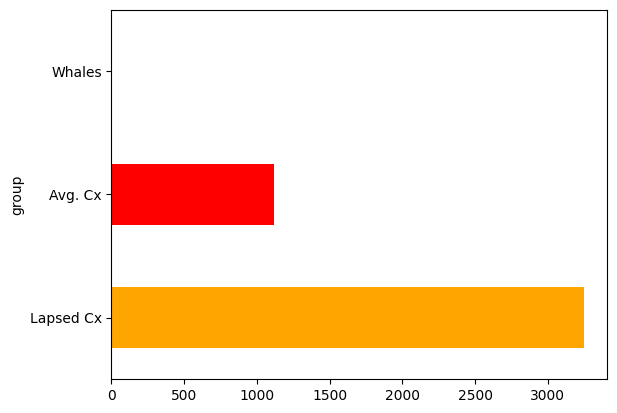

In [84]:
result.plot(kind="barh", color=["Orange","Red","Green"])

# Implementing classifiers for Segmentation, with labels being countries

## PreProcessing

In [85]:
segment_df = df.copy()

In [86]:
segment_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [87]:
segment_df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0
total,0


In [88]:
segment_df = segment_df[pd.notnull(segment_df['CustomerID'])]

In [89]:
segment_df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
total,0


In [90]:
# Remove cancelled orders
segment_df = segment_df[segment_df["Quantity"] > 0]

# Convert the InvoiceDate column to datetime
segment_df["InvoiceDate"] = pd.to_datetime(segment_df["InvoiceDate"])

# Create a TotalPrice column
segment_df["TotalPrice"] = segment_df["Quantity"] * segment_df["UnitPrice"]

In [93]:
from datetime import datetime
rfm_segment_cust = segment_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (datetime.now() - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        'TotalPrice': lambda x: x.sum(),    # Monetary Value
                                        'Country' : lambda x: x })
rfm_segment_cust['InvoiceDate'] = rfm_segment_cust['InvoiceDate'].astype(int)
rfm_segment_cust.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [94]:
rfm_segment_cust

,recency,frequency,monetary_value,Country
CustomerID,,,,
12346.0,5137,1,77183.60,United Kingdom
12347.0,4814,182,4310.00,"[Iceland, Iceland, Iceland, Iceland, Iceland, ..."
12348.0,4887,31,1797.24,"[Finland, Finland, Finland, Finland, Finland, ..."
12349.0,4830,73,1757.55,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
12350.0,5122,17,334.40,"[Norway, Norway, Norway, Norway, Norway, Norwa..."
...,...,...,...,...
18280.0,5089,10,180.60,"[United Kingdom, United Kingdom, United Kingdo..."
18281.0,4992,7,80.82,"[United Kingdom, United Kingdom, United Kingdo..."
18282.0,4819,12,178.05,"[United Kingdom, United Kingdom, United Kingdo..."


In [95]:
for i in range(len(rfm_segment_cust['Country'].values)) :
  if type(rfm_segment_cust['Country'].values[i]) == str:
    continue
  else :
    for j in range(len(rfm_segment_cust['Country'].values[i])) :
      rfm_segment_cust['Country'].values[i] = rfm_segment_cust['Country'].values[i][j]
      break

In [96]:
rfm_segment_cust

,recency,frequency,monetary_value,Country
CustomerID,,,,
12346.0,5137,1,77183.60,United Kingdom
12347.0,4814,182,4310.00,Iceland
12348.0,4887,31,1797.24,Finland
12349.0,4830,73,1757.55,Italy
12350.0,5122,17,334.40,Norway
...,...,...,...,...
18280.0,5089,10,180.60,United Kingdom
18281.0,4992,7,80.82,United Kingdom
18282.0,4819,12,178.05,United Kingdom


In [97]:
rfm_segment_cust.nunique()

,0
recency,304
frequency,461
monetary_value,4277
Country,37


In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    rfm_segment_cust[["recency", "frequency", "monetary_value"]],
    rfm_segment_cust["Country"],
    test_size=0.2,
    random_state=42
)

## Random Forest Classifier

In [99]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Evaluating the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.8870967741935484
Precision: 0.7908068241078745
Recall: 0.8870967741935484
F1 Score: 0.8361889007050297


In [100]:
customer_types = rfc.predict(rfm_segment_cust[["recency", "frequency", "monetary_value"]])
rfm_segment_cust["CustomerType"] = customer_types

<Axes: title={'center': 'Customer Types'}, xlabel='CustomerType'>

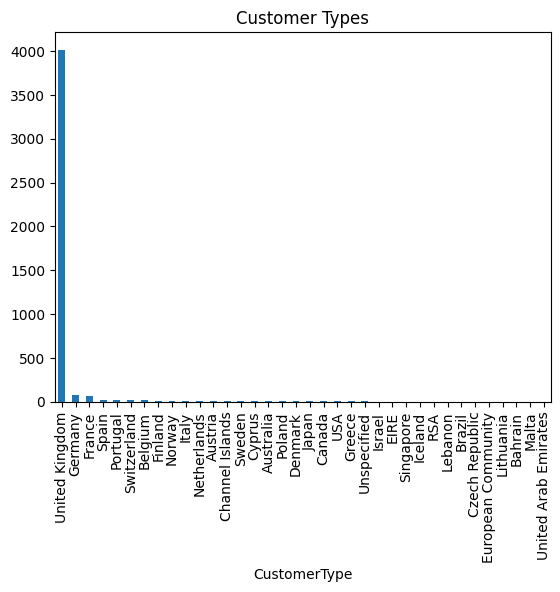

In [101]:
customer_type_counts = rfm_segment_cust["CustomerType"].value_counts()
customer_type_counts.plot(kind="bar", title="Customer Types")

## SVD and KNN Classifier

In [102]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_svd, y_train)
knn_y_pred = knn.predict(X_test_svd)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, average='weighted')
knn_recall = recall_score(y_test, knn_y_pred, average='weighted')
knn_f1_score = f1_score(y_test, knn_y_pred, average='weighted')

In [103]:
print("\nSVD and KNN Classifier:")
print("Accuracy:", knn_accuracy)
print("Precision Score:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1_score)


SVD and KNN Classifier:
Accuracy: 0.8870967741935484
Precision Score: 0.7908068241078745
Recall: 0.8870967741935484
F1 Score: 0.8361889007050297


## PCA and Decision Tree Classifier

In [104]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_pca, y_train)
dtc_y_pred = dtc.predict(X_test_pca)
dtc_accuracy = accuracy_score(y_test, dtc_y_pred)
dtc_precision = precision_score(y_test, dtc_y_pred, average='weighted')
dtc_recall = recall_score(y_test, dtc_y_pred, average='weighted')
dtc_f1_score = f1_score(y_test, dtc_y_pred, average='weighted')

In [105]:
print("\nPCA and Decision Tree Classifier:")
print("Accuracy:", dtc_accuracy)
print("Precision Score:", dtc_precision)
print("Recall:", dtc_recall)
print("F1 Score:", dtc_f1_score)


PCA and Decision Tree Classifier:
Accuracy: 0.8052995391705069
Precision Score: 0.7935128256371673
Recall: 0.8052995391705069
F1 Score: 0.7993335300231158


## LDA and KNN Classifier

In [106]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

knn_lda = KNeighborsClassifier()
knn_lda.fit(X_train_lda, y_train)
knn_lda_y_pred = knn_lda.predict(X_test_lda)
knn_lda_accuracy = accuracy_score(y_test, knn_lda_y_pred)
knn_lda_precision = precision_score(y_test, knn_lda_y_pred, average='weighted')
knn_lda_recall = recall_score(y_test, knn_lda_y_pred, average='weighted')
knn_lda_f1_score = f1_score(y_test, knn_lda_y_pred, average='weighted')

In [107]:
print("\nLDA and KNN Classifier:")
print("Accuracy:", knn_lda_accuracy)
print("Precision Score:", knn_lda_precision)
print("Recall:", knn_lda_recall)
print("F1 Score:", knn_lda_f1_score)


LDA and KNN Classifier:
Accuracy: 0.8847926267281107
Precision Score: 0.7914946788344165
Recall: 0.8847926267281107
F1 Score: 0.8355472878704604
